In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

[utils.py:54 - get_tautomer_transformation()] Index of atom that moves: 11.
[utils.py:60 - get_tautomer_transformation()] Index of atom that donates hydrogen: 2
[utils.py:78 - get_tautomer_transformation()] Index of atom that accepts hydrogen: 5


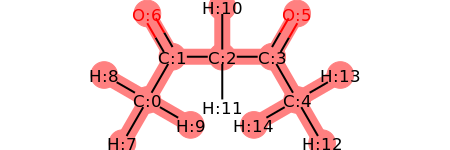

In [3]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit molhttp://localhost:8888/notebooks/notebooks/testing-hybrid-structures.ipynb#
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

tautomer_transformation = neutromeratio.get_tautomer_transformation(from_mol, to_mol)
neutromeratio.generate_hybrid_structure(ani_input, tautomer_transformation, neutromeratio.ani.ANI1_force_and_energy)

In [4]:
# define the alchemical atoms
alchemical_atoms=[tautomer_transformation['acceptor_hydrogen_idx'], tautomer_transformation['donor_hydrogen_idx']]

In [5]:
tautomer_transformation

{'donor_idx': 2,
 'hydrogen_idx': 11,
 'acceptor_idx': 5,
 'donor_hydrogen_idx': 11,
 'acceptor_hydrogen_idx': 15}

In [10]:
np.random.seed(0)

# extract hydrogen donor idx and hydrogen idx for from_mol
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalSingleTopologyANI(device=device, alchemical_atoms=alchemical_atoms, ani_input=ani_input)
model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
ani_trajs = []
n_steps = 5000
energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['hybrid_atoms'],
                                          platform = platform,
                                          tautomer_transformation = tautomer_transformation)
energy_function.restrain_acceptor = True
energy_function.restrain_donor = True

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['hybrid_atoms'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)

x0 = np.array(ani_input['hybrid_coords']) * unit.angstrom
energie_list = []


for lamb in np.linspace(0, 1, 10):
    print(lamb)
    energy_function.lambda_value = lamb
    
    equilibrium_samples, energies = langevin.run_dynamics(x0, n_steps, stepsize=1.0 * unit.femtosecond)
    energie_list.append(energies)
    equilibrium_samples = [x / unit.nanometer for x in equilibrium_samples]
    ani_traj = md.Trajectory(equilibrium_samples, ani_input['hybrid_topolog'])

    ani_trajs.append(ani_traj)

1
1


KeyboardInterrupt: 

In [21]:
import ase

ModuleNotFoundError: No module named 'ase'

In [ ]:
calculator = torchani.models.ANI1ccx().ase()


In [20]:
import torchani


ModuleNotFoundError: No module named 'ase'

In [11]:
neutromeratio.utils.generate_nglview_object(ani_trajs[0], tautomer_transformation)

Hydrogen in GREEN  is real at lambda: 0.
Hydrogen in YELLOW is real at lambda: 1.


NGLWidget(count=5001)

In [ ]:
import matplotlib.pyplot as plt

for energy in energie_list:
    e = [x / unit.kilocalorie_per_mole for x in energy]
    plt.plot(e, label='lambda: {}'.format(str(lamb)))

In [12]:
def f(x):
    return energy_function.calculate_energy(x)

def df(x):
    f, e = energy_function.calculate_force(x)
    return f._value

In [13]:
x = x0.in_units_of(unit.nanometer)

for i in range(1, 10000):
    print(i)
    s = df(x)
    x = x.value_in_unit(unit.nanometer) + 0.0001 * s
    x = x * unit.nanometer
    print(x)

1
[[-0.42235124 -0.1441461  -0.07882141]
 [-0.18075646  0.32883311  0.03507011]
 [ 0.09712491 -0.35098102 -0.06222395]
 [ 0.43086509  0.66012847 -0.52332843]
 [ 0.26869094 -0.00882623  0.02928396]
 [-0.45160764 -0.62634854  0.54843699]
 [-0.20871936  0.16927842 -0.05712771]
 [-0.21105018 -0.02286084 -0.04072532]
 [-0.15759847 -0.16339753 -0.01590826]
 [-0.19629573 -0.03772499  0.00837074]
 [ 0.07255393  0.15471418 -0.14225127]
 [ 0.05831622  0.16532325 -0.03207628]
 [ 0.27372366 -0.05783307 -0.07357259]
 [ 0.24090618  0.04853718 -0.0668929 ]
 [ 0.22530991 -0.10017126  0.01293603]
 [ 0.10206773 -0.12959656  0.09403574]] nm
2
[[-0.67148685 -0.2497349  -0.1352129 ]
 [-0.18038566  0.43653029  0.10229953]
 [ 0.10271737 -0.47162633 -0.13019947]
 [ 0.43086509  0.66012847 -0.52332843]
 [ 0.24758386  0.0673937  -0.16838725]
 [ 0.82534594  0.5193214  -0.49955846]
 [-0.30535151  0.15600607 -0.10859463]
 [-0.15051644  0.19030517 -0.13453253]
 [-0.1611203  -0.07942845  0.05718358]
 [-0.07028941 -0.

[[-6.79065357e-01 -4.85625108e-01 -2.18814703e-01]
 [-2.56059721e-01  4.99008793e-01  1.32590949e-01]
 [ 1.30699551e-01 -2.76979893e-01 -1.69193312e-01]
 [ 4.61428232e-01  6.46330181e-01 -5.10282546e-01]
 [-1.26980421e+00  1.13382228e-02  2.49639690e-01]
 [ 1.42780341e+06  1.31882418e+06 -1.28868080e+06]
 [ 1.95472877e+00 -3.40097102e-02 -5.03668240e-01]
 [-6.57866989e-01  3.18792266e-01  4.13699899e-02]
 [-5.21807462e-01 -3.83212700e-02  2.33864337e-01]
 [-4.95706095e-02 -4.11130267e-01  2.45440019e-01]
 [ 4.44679025e-02  7.01197874e-01 -6.88764163e-01]
 [ 9.47612525e-02 -1.01375443e-01 -9.86520113e-02]
 [ 9.99971451e-01 -3.49517907e-01 -8.17233099e-01]
 [ 2.13511526e-01  5.07109890e-01  2.86884970e-01]
 [-3.48464965e-01 -4.69362606e-01  8.14592575e-01]
 [-1.42780359e+06 -1.31882481e+06  1.28868144e+06]] nm
13
[[-6.79065357e-01 -4.85625108e-01 -2.18814703e-01]
 [-2.28408061e-01  5.05672413e-01  1.40219988e-01]
 [ 1.27376456e-01 -2.72769119e-01 -1.61950276e-01]
 [ 4.70291845e-01  6.451

[[-6.79065357e-01 -4.85625108e-01 -2.18814703e-01]
 [-2.29154706e-01  5.07778148e-01  1.39374022e-01]
 [ 1.23078629e-01 -2.52380067e-01 -1.53477698e-01]
 [ 4.70516133e-01  6.45134308e-01 -5.06392432e-01]
 [-1.26980421e+00  1.13382228e-02  2.49639690e-01]
 [-9.94308810e+12 -9.18416933e+12  8.97425344e+12]
 [ 1.95472877e+00 -3.40097102e-02 -5.03668240e-01]
 [-6.72467120e-01  3.15538730e-01  3.66404587e-02]
 [-5.20884871e-01 -4.28179664e-02  2.35972956e-01]
 [-4.72768680e-02 -4.09179746e-01  2.40149673e-01]
 [ 3.53800009e-02  7.02393747e-01 -6.92654277e-01]
 [ 1.00088432e-01 -1.27925790e-01 -1.09077279e-01]
 [ 9.99971451e-01 -3.49517907e-01 -8.17233099e-01]
 [ 2.00284047e-01  5.06090767e-01  2.82722811e-01]
 [-3.48464965e-01 -4.69362606e-01  8.14592575e-01]
 [ 9.94308810e+12  9.18416933e+12 -8.97425344e+12]] nm
24
[[-6.79065357e-01 -4.85625108e-01 -2.18814703e-01]
 [-2.54862713e-01  5.02324537e-01  1.32088184e-01]
 [ 1.26683775e-01 -2.48505665e-01 -1.61841139e-01]
 [ 4.61189329e-01  6.463

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.22899227  0.510389    0.1386824 ]
 [ 0.12256708 -0.25010185 -0.15246036]
 [ 0.47054329  0.64513074 -0.50638081]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.6709959   0.31492384  0.03729499]
 [-0.52150597 -0.04383462  0.23611817]
 [-0.04724153 -0.40911937  0.24006635]
 [ 0.03535285  0.70239732 -0.6926659 ]
 [ 0.10056464 -0.13026439 -0.11001129]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.19927149  0.50511146  0.28261469]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
36
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25542544  0.50493671  0.131155  ]
 [ 0.12639224 -0.24651723 -0.16130267]
 [ 0.46117134  0.64636399 -0.51039251]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65672918  0.31681309  0.04227913]
 [-0.5230611  -0.04010249  0.23404983]
 [-0.05106708 -0.4

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25549519  0.50762053  0.13038008]
 [ 0.12634775 -0.24628979 -0.16121595]
 [ 0.46117019  0.64636413 -0.510393  ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65569829  0.31661977  0.04260391]
 [-0.52341519 -0.04146069  0.23443206]
 [-0.051071   -0.41271142  0.24891883]
 [ 0.04472594  0.70116392 -0.68865371]
 [ 0.10061344 -0.1304844  -0.11010819]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.21238602  0.50381007  0.28729419]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
49
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.22924816  0.51354679  0.13771473]
 [ 0.12251986 -0.24986188 -0.15236822]
 [ 0.47054513  0.64513049 -0.50638002]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66960267  0.31398015  0.03800953]
 [-0.52216012 -0.04485807  0.23625208]
 [-0.04724651 -0.4

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25570985  0.51113027  0.12934522]
 [ 0.12633354 -0.2462248  -0.16118779]
 [ 0.46117011  0.64636415 -0.51039304]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65445274  0.31642295  0.04295421]
 [-0.52371845 -0.04320617  0.23498415]
 [-0.05107087 -0.41271303  0.24891864]
 [ 0.04472602  0.7011639  -0.68865367]
 [ 0.10062752 -0.13054778 -0.11013616]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.21165838  0.50224263  0.28742667]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
65
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.22951688  0.51702066  0.13667366]
 [ 0.12251076 -0.24980931 -0.15235083]
 [ 0.4705452   0.64513049 -0.50637999]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66799655  0.31289047  0.03882877]
 [-0.52276727 -0.04582271  0.23638129]
 [-0.04724865 -0.4

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.22974924  0.51991686  0.13582553]
 [ 0.12250937 -0.24980109 -0.15234819]
 [ 0.47054518  0.64513049 -0.50638   ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66664166  0.31191317  0.03952787]
 [-0.52314858 -0.04645111  0.23647067]
 [-0.04724901 -0.40912634  0.24008364]
 [ 0.03535095  0.70239756 -0.69266671]
 [ 0.10062983 -0.13055818 -0.11014075]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.19731684  0.50121075  0.28288619]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
80
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25596604  0.51445517  0.12837347]
 [ 0.12633116 -0.24621419 -0.16118305]
 [ 0.4611701   0.64636416 -0.51039304]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65328749  0.31636765  0.04320879]
 [-0.5237887  -0.04485245  0.23559211]
 [-0.0510708  -0.4

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25618677  0.51680781  0.12769553]
 [ 0.12633081 -0.24621264 -0.16118236]
 [ 0.4611701   0.64636416 -0.51039304]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65252268  0.31641354  0.04331578]
 [-0.52366298 -0.04599893  0.23608668]
 [-0.05107079 -0.41271327  0.24891847]
 [ 0.04472603  0.7011639  -0.68865367]
 [ 0.10063017 -0.13055969 -0.11014142]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.21014979  0.49936726  0.28761226]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
93
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.23002456  0.52263734  0.13503698]
 [ 0.12250908 -0.2497994  -0.15234764]
 [ 0.47054519  0.64513049 -0.50638   ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66536308  0.3109268   0.04019322]
 [-0.52335992 -0.04685128  0.23654005]
 [-0.04724908 -0.4

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.23039094  0.52549331  0.1342241 ]
 [ 0.12250903 -0.24979904 -0.15234753]
 [ 0.47054518  0.6451305  -0.50638   ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66404853  0.30985704  0.04086363]
 [-0.52334705 -0.04706347  0.23662757]
 [-0.0472491  -0.40912641  0.24008385]
 [ 0.03535095  0.70239756 -0.69266671]
 [ 0.10063027 -0.13056015 -0.11014162]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.19556388  0.4983028   0.28299495]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
110
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25657143  0.52005891  0.12677689]
 [ 0.12633072 -0.24621217 -0.16118217]
 [ 0.4611701   0.64636416 -0.51039304]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65155194  0.31657911  0.04335701]
 [-0.52317957 -0.04748832  0.2368606 ]
 [-0.0510708  -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.23081055  0.52808703  0.13350368]
 [ 0.12250901 -0.24979899 -0.1523475 ]
 [ 0.4705452   0.6451305  -0.50638   ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66292016  0.30894479  0.04138798]
 [-0.52304282 -0.04712289  0.23677502]
 [-0.0472491  -0.40912641  0.24008384]
 [ 0.03535094  0.70239756 -0.69266671]
 [ 0.10063029 -0.13056021 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.19455088  0.49668075  0.28304357]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
126
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25696712  0.52267891  0.12605624]
 [ 0.12633072 -0.2462121  -0.16118219]
 [ 0.46117012  0.64636416 -0.51039304]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.6508204   0.31670821  0.04333647]
 [-0.52250982 -0.04847967  0.23751954]
 [-0.05107082 -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.23121371  0.53019128  0.13293351]
 [ 0.122509   -0.24979899 -0.15234747]
 [ 0.47054518  0.6451305  -0.50638001]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66206756  0.30829853  0.04172473]
 [-0.52256884 -0.04712583  0.23697075]
 [-0.04724909 -0.40912639  0.24008382]
 [ 0.03535095  0.70239755 -0.6926667 ]
 [ 0.10063029 -0.13056022 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.19362747  0.49522569  0.28308125]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
140
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25734975  0.52481202  0.12548326]
 [ 0.12633071 -0.2462121  -0.16118216]
 [ 0.4611701   0.64636416 -0.51039305]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.6502283   0.31674753  0.04331892]
 [-0.52180103 -0.0490821   0.2380454 ]
 [-0.0510708  -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25769854  0.52656101  0.1250226 ]
 [ 0.1263307  -0.24621211 -0.16118214]
 [ 0.4611701   0.64636416 -0.51039305]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.64973699  0.31673175  0.04330993]
 [-0.52112918 -0.04944662  0.23846506]
 [-0.05107079 -0.41271327  0.24891849]
 [ 0.04472603  0.70116389 -0.68865366]
 [ 0.10063029 -0.13056022 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.20634207  0.49274354  0.28791266]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
153
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.23164221  0.53219367  0.13240295]
 [ 0.122509   -0.24979899 -0.15234748]
 [ 0.47054519  0.6451305  -0.50638   ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66129903  0.30775868  0.04197775]
 [-0.52195247 -0.04710251  0.23721576]
 [-0.04724909 -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25818651  0.52881767  0.12444028]
 [ 0.12633071 -0.24621209 -0.16118217]
 [ 0.46117012  0.64636416 -0.51039304]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.64909449  0.31666652  0.04330033]
 [-0.52015918 -0.04978096  0.23899844]
 [-0.05107081 -0.41271328  0.24891852]
 [ 0.04472601  0.70116389 -0.68865367]
 [ 0.10063029 -0.13056023 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.20521755  0.49088644  0.2879712 ]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
169
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.23215546  0.53440123  0.13183145]
 [ 0.12250901 -0.24979897 -0.15234751]
 [ 0.47054518  0.6451305  -0.50638001]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.66048194  0.30722358  0.04219966]
 [-0.52112314 -0.0470413   0.23753535]
 [-0.0472491  -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.23268883  0.53655359  0.13128751]
 [ 0.122509   -0.24979898 -0.15234748]
 [ 0.4705452   0.6451305  -0.50638   ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.6597024   0.30674637  0.04237214]
 [-0.52019382 -0.04694648  0.23788516]
 [-0.04724909 -0.40912639  0.24008383]
 [ 0.03535094  0.70239756 -0.69266671]
 [ 0.10063029 -0.13056023 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.1903624   0.4902362   0.28316544]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
186
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25875957  0.53129077  0.1238177 ]
 [ 0.12633071 -0.24621209 -0.16118218]
 [ 0.46117012  0.64636416 -0.51039304]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.64837761  0.31655472  0.04328849]
 [-0.51898552 -0.05000986  0.23957852]
 [-0.05107081 -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.2332386   0.53867033  0.13076532]
 [ 0.122509   -0.24979898 -0.15234748]
 [ 0.47054519  0.6451305  -0.50638001]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65894111  0.30630633  0.04251067]
 [-0.51918686 -0.04681824  0.23825637]
 [-0.04724909 -0.40912639  0.24008383]
 [ 0.03535094  0.70239756 -0.6926667 ]
 [ 0.10063029 -0.13056023 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.18914392  0.48843126  0.28317788]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
202
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.2592863   0.53345233  0.12328681]
 [ 0.12633071 -0.24621209 -0.16118218]
 [ 0.46117011  0.64636416 -0.51039305]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.64773906  0.31643862  0.0432726 ]
 [-0.51787923 -0.0501223   0.2400879 ]
 [-0.05107081 -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.25968991  0.5350586   0.12290064]
 [ 0.12633071 -0.24621209 -0.16118218]
 [ 0.46117011  0.64636416 -0.51039305]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.64725741  0.31634524  0.04325635]
 [-0.51701476 -0.05016261  0.24046925]
 [-0.05107081 -0.41271328  0.24891852]
 [ 0.04472602  0.70116389 -0.68865366]
 [ 0.10063029 -0.13056023 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.20173944  0.48534845  0.28808401]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
215
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.2337311   0.54050284  0.13032365]
 [ 0.12250899 -0.24979899 -0.15234747]
 [ 0.4705452   0.6451305  -0.50638   ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65828201  0.305943    0.04261036]
 [-0.51825228 -0.04668018  0.2385954 ]
 [-0.04724909 -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.2341609   0.5420634   0.12995518]
 [ 0.12250901 -0.24979897 -0.15234751]
 [ 0.4705452   0.6451305  -0.50638   ]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65771812  0.3056446   0.04268252]
 [-0.51741627 -0.04654436  0.2388954 ]
 [-0.0472491  -0.4091264   0.24008385]
 [ 0.03535094  0.70239756 -0.69266671]
 [ 0.10063029 -0.13056023 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.18707264  0.48542605  0.28317715]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
228
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.26016905  0.53692158  0.12246171]
 [ 0.1263307  -0.2462121  -0.16118215]
 [ 0.46117012  0.64636416 -0.51039304]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.64668989  0.31623159  0.04323273]
 [-0.51597209 -0.05016957  0.24091509]
 [-0.05107079 -0.

[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.260726    0.53904148  0.1219742 ]
 [ 0.12633071 -0.2462121  -0.16118216]
 [ 0.46117006  0.64636417 -0.51039307]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.64603171  0.31609744  0.04319943]
 [-0.51473903 -0.05013238  0.24142756]
 [-0.0510708  -0.41271328  0.24891851]
 [ 0.04472607  0.70116389 -0.68865364]
 [ 0.10063029 -0.13056023 -0.11014165]
 [ 0.99997145 -0.34951791 -0.8172331 ]
 [ 0.1992741   0.48158314  0.28810905]
 [-0.34846497 -0.46936261  0.81459257]
 [        nan         nan         nan]] nm
245
[[-0.67906536 -0.48562511 -0.2188147 ]
 [-0.23481696  0.54439282  0.12941863]
 [ 0.122509   -0.24979898 -0.1523475 ]
 [ 0.47054526  0.64513049 -0.50637998]
 [-1.26980421  0.01133822  0.24963969]
 [        nan         nan         nan]
 [ 1.95472877 -0.03400971 -0.50366824]
 [-0.65686898  0.30521498  0.04277122]
 [-0.51610833 -0.04631285  0.23936017]
 [-0.0472491  -0.

KeyboardInterrupt: 

In [14]:
energy_function?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

function = lambda x: (x ** 3)-(3 *(x ** 2))+7

#Get 1000 evenly spaced numbers between -1 and 3 (arbitratil chosen to ensure steep curve)
x = np.linspace(-1,3,500)

#Plot the curve
plt.plot(x, function(x))
plt.show()


In [ ]:
step(0.5, 0, 0.001, 0.05)
